# Análisis Exploratorio de los Datos

In [ ]:
import pandas as pd
import numpy as np
import json
import gzip
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
juegos = pd.read_csv('/content/drive/MyDrive/games.csv')
print(juegos.head())
print(juegos.shape)
items = pd.read_csv('/content/drive/MyDrive/items.csv')
print(items.head())
print(items.shape)
reviews = pd.read_csv('/content/drive/MyDrive/reviews.csv')
print(reviews.head())
print(reviews.shape)

   item_id                 app_name  \
0   761140      Lost Summoner Kitty   
1   643980                Ironbound   
2   670290  Real Pool 3D - Poolians   
3   767400                  弹炸人2222   
4   773570            Log Challenge   

                                              genres         price  \
0  ['Action', 'Casual', 'Indie', 'Simulation', 'S...          4.99   
1       ['Free to Play', 'Indie', 'RPG', 'Strategy']  Free To Play   
2  ['Casual', 'Free to Play', 'Indie', 'Simulatio...  Free to Play   
3                  ['Action', 'Adventure', 'Casual']          0.99   
4            ['Action', 'Indie', 'Casual', 'Sports']          2.99   

  release_date         developer  
0   2018-01-04         Kotoshiro  
1   2018-01-04  Secret Level SRL  
2   2017-07-24      Poolians.com  
3   2017-12-07              彼岸领域  
4   2018-01-04          CGPills   
(32133, 6)
   item_id  playtime_forever            user_id
0       10                 6  76561197970982479
1       20                 

## Añadir columna año, columna free (para Free to Play) y formatear columna price

In [ ]:
import re

juegos.release_date = pd.to_datetime(juegos.release_date)
juegos['año'] = juegos.release_date.dt.year
juegos["free"] = juegos.price.apply(lambda x: "free to play".find(x.lower().strip()) >= 0)
patron = re.compile('[+|-]?[0-9]*\.[0-9]+')
juegos["price"] = juegos.price.apply(lambda x: float(x) if patron.fullmatch(x) else 0)
juegos["price"] = juegos.price.astype(float, errors='ignore')

# Juegos

## Información general

In [ ]:
juegos.head()

,item_id,app_name,genres,price,release_date,developer,año,free
0,761140,Lost Summoner Kitty,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",4.99,2018-01-04,Kotoshiro,2018.0,False
1,643980,Ironbound,"['Free to Play', 'Indie', 'RPG', 'Strategy']",0.00,2018-01-04,Secret Level SRL,2018.0,True
2,670290,Real Pool 3D - Poolians,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",0.00,2017-07-24,Poolians.com,2017.0,True
3,767400,弹炸人2222,"['Action', 'Adventure', 'Casual']",0.99,2017-12-07,彼岸领域,2017.0,False
4,773570,Log Challenge,"['Action', 'Indie', 'Casual', 'Sports']",2.99,2018-01-04,CGPills,2018.0,False


In [ ]:
juegos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   item_id       32133 non-null  int64         
 1   app_name      32133 non-null  object        
 2   genres        32133 non-null  object        
 3   price         32133 non-null  float64       
 4   release_date  31916 non-null  datetime64[ns]
 5   developer     31555 non-null  object        
 6   año           31916 non-null  float64       
 7   free          32133 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.7+ MB


<p>Como era de esperar, existen algunos pocos nulos en las columnas prelease_date, año y developer. Este aspecto se abordó en el ETL inicial.

In [ ]:
juegos.describe()

,item_id,price,release_date,año
count,3.213300e+04,32133.000000,31916,31916.000000
mean,4.517446e+05,8.640054,2015-05-09 11:28:08.783055616,2014.809563
min,1.000000e+01,0.000000,1970-01-01 00:00:00,1970.000000
25%,3.292700e+05,1.990000,2014-11-18 00:00:00,2014.000000
50%,4.520000e+05,4.990000,2016-05-31 00:00:00,2016.000000
75%,5.933900e+05,9.990000,2017-05-03 00:00:00,2017.000000
max,2.028850e+06,995.000000,2024-04-02 00:00:00,2024.000000
std,1.827172e+05,15.725941,NaN,3.909274


<p>La información proporcionada por describe brinda algunos datos interesantes:

- El precio varía entre 0 y 995 dólares (esto se explorará más adelante, para determinar qué tipo de outliers son), aunque la mayoría de juegos parece no costar más de 10 dólares.
- Hay juegos con fechas entre los años 1970 y 2024 (debido a la imputación de datos realizada en el ETL), pero la mayoría data de después de 2010.

In [ ]:
juegos.describe(include=['O'])

,app_name,genres,developer
count,32133,32133,31555
unique,32094,1523,12970
top,Soundtrack,['Action'],Ubisoft - San Francisco
freq,3,2058,1259


<p>Teniendo en cuenta la estructura del dataset, la información proporcionada por describe para objects parece no ser muy determinante, aunque se destaca que la categoría Action por sí sola es la que aparece con mayor frecuencia entre los datos, por lo que es seguro afirmar que el género Action es el más común entre los juegos. Esto, sin embargo, se contrastará más adelante.

## Importar archivos de géneros y desarrolladores

In [ ]:
generos = pd.read_csv('/content/drive/MyDrive/genres.csv')
print(generos.head())
print(generos.shape)
dev = pd.read_csv('/content/drive/MyDrive/developers.csv')
print(dev.head())
print(dev.shape)

                   genre
0  Massively Multiplayer
1              Adventure
2         Web Publishing
3                    RPG
4              Education
(22, 1)
                                   0
0                                NaN
1  KADOKAWA,Yoji Ojima,Hiroki Kikuta
2                     Matt Glanville
3                         Koth Studo
4                            Mathias
(12972, 1)


In [ ]:
dev.dropna(inplace=True)
dev.reset_index(drop=True, inplace=True)

##Variables numéricas

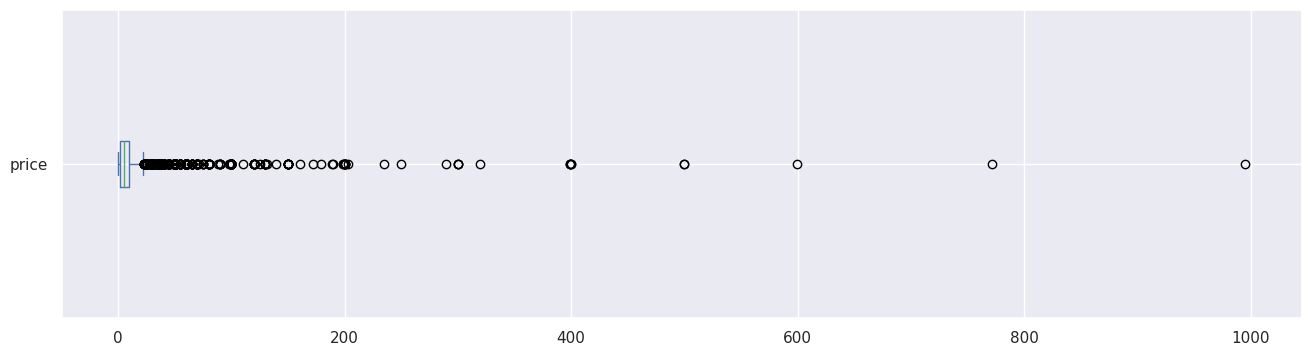

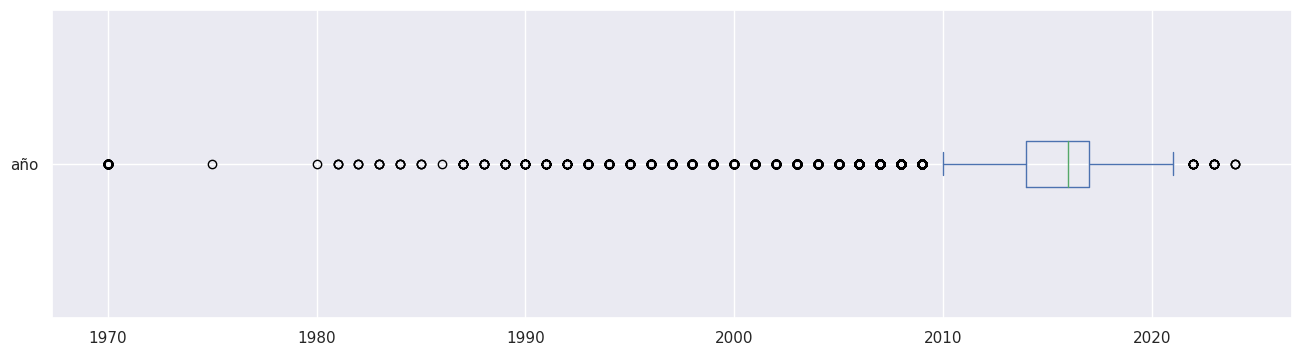

In [ ]:
num_vars = ["price", "año"]
for var in num_vars:
  juegos[var].plot.box(vert=False, figsize=(16,4))
  plt.show()

### Precio

<p>Como se comentó anteriormente, la mayoría de los datos para ambas columnas está en un rango mucho menor al que cubren todos los datos.

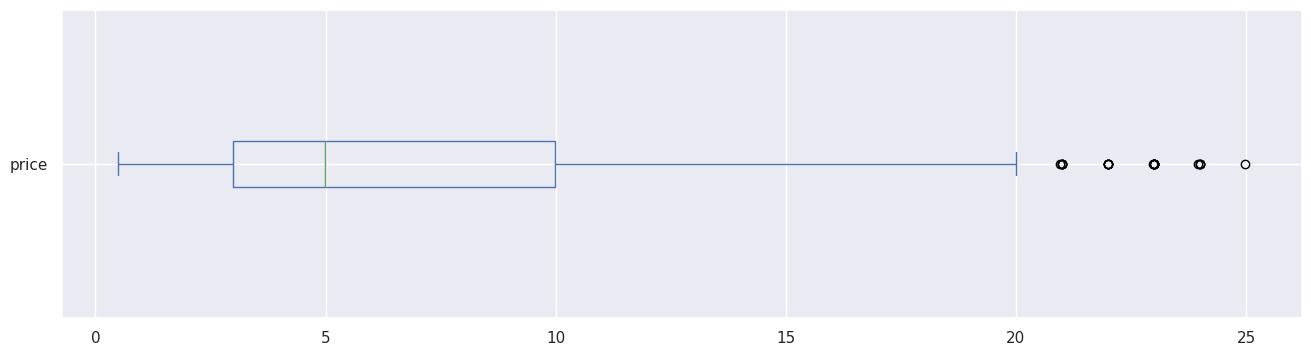

In [ ]:
lim_inf = juegos["price"].quantile(0)
lim_sup = juegos["price"].quantile(0.95)
mask = (juegos["price"] > lim_inf) & (juegos["price"] < lim_sup)
juegos["price"][mask].plot.box(vert=False, figsize=(16,4))
plt.show()

In [ ]:
juegos.price.mean()

8.640054461145862

<p>La anterior gráfica muestra de forma mucho más clara que la mayoría de los precios están entre 0 y 20 dólares (considerando que se imputaron como cero los precios indicados por textos como Free to Play, Demo, etc.).

In [ ]:
juegos.sort_values(by="price", ascending=False).head(10)

,item_id,app_name,genres,price,release_date,developer,año,free
12087,719000,Strata Spaces VR – Professional Edition Upgrade,"['Animation and Modeling', 'Design and Illustr...",995.00,2017-10-26,"Strata Mixed Reality, Inc.",2017.0,False
2391,292180,X-Plane 10 Global - 64 Bit,['Simulation'],771.71,2014-07-14,Laminar Research,2014.0,False
23592,358040,HTC Vive,"['Simulation', 'Action', 'RPG', 'Free to Play']",599.00,2016-04-05,NaN,2016.0,False
14303,691560,CUR3D Maker Edition - Permission for commercia...,"['Animation and Modeling', 'Design and Illustr...",499.99,2017-11-06,RUHRSOURCE GmbH,2017.0,False
17792,629796,EVE Online: 15400 PLEX,"['Free to Play', 'Massively Multiplayer', 'RPG']",499.99,2017-05-09,CCP,2017.0,False
9073,585620,GameMaker Studio 2 Mobile,"['Animation and Modeling', 'Design and Illustr...",399.99,2017-03-08,YoYo Games Ltd.,2017.0,False
9074,585610,GameMaker Studio 2 UWP,"['Animation and Modeling', 'Design and Illustr...",399.99,2017-03-08,YoYo Games Ltd.,2017.0,False
13754,750840,MAGIX Video Pro X9 Steam Edition,['Video Production'],399.00,2017-11-28,MAGIX Software GmbH,2017.0,False
9416,598860,MAGIX Video Pro X8 Steam Edition,['Video Production'],399.00,2017-04-11,MAGIX Software GmbH,2017.0,False
15844,689790,VEGAS Pro 15 Edit Steam Edition,"['Audio Production', 'Video Production']",399.00,2017-09-05,MAGIX Software GmbH,2017.0,False


<p>La tabla anterior muestra que los juegos más caros cuestan desde 399 dólares en adelante, y fueron desarrollados en 2014, 2016 y 2017.

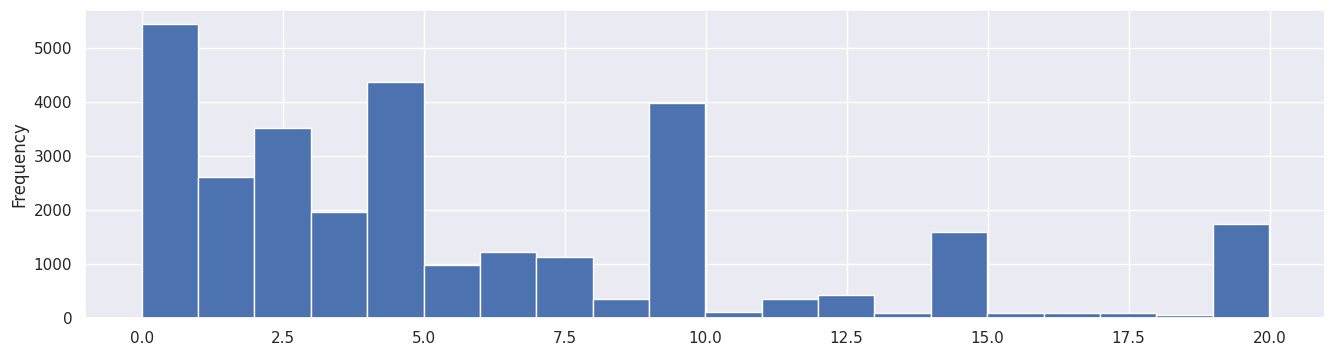

In [ ]:
mask = (juegos.price >= 0) & (juegos.price < 20)
juegos.price[mask].plot.hist(figsize=(16,4), bins=20)
plt.show()

<p>Asimismo, el histograma muestra que la mayoría de aplicaciones cuesta 10 dólares o menos (y que es mucho más común que los precios sean múltiplos de 5).

### Año

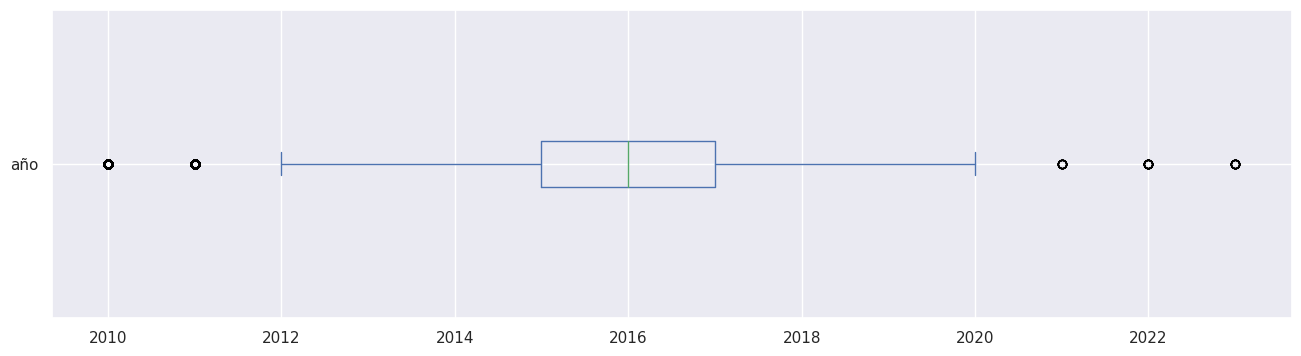

In [ ]:
lim_inf = juegos["año"].quantile(0.05)
lim_sup = juegos["año"].quantile(1)
mask = (juegos["año"] > lim_inf) & (juegos["año"] < lim_sup)
juegos["año"][mask].plot.box(vert=False, figsize=(16,4))
plt.show()

In [ ]:
round(juegos.año.mean())

2015

<p>Como denota la anterior gráfica, la mayoría de juegos datan de entre 2012 y 2020.

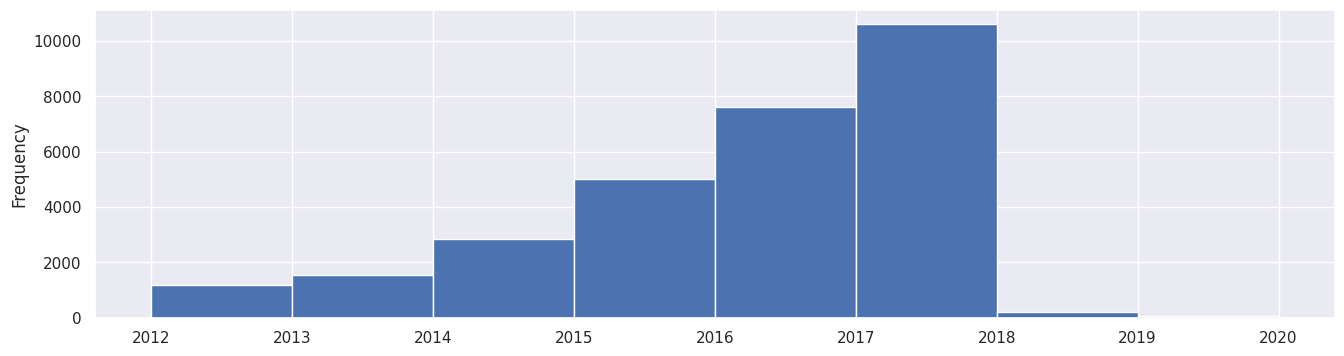

In [ ]:
mask = (juegos.año >= 2012) & (juegos.año <= 2020)
juegos.año[mask].plot.hist(figsize=(16,4), bins=8)
plt.show()

<p>Como es de esperar, en realidad la mayoría de juegos data de entre 2012 y 2017

## Variables categóricas

### Free to Play

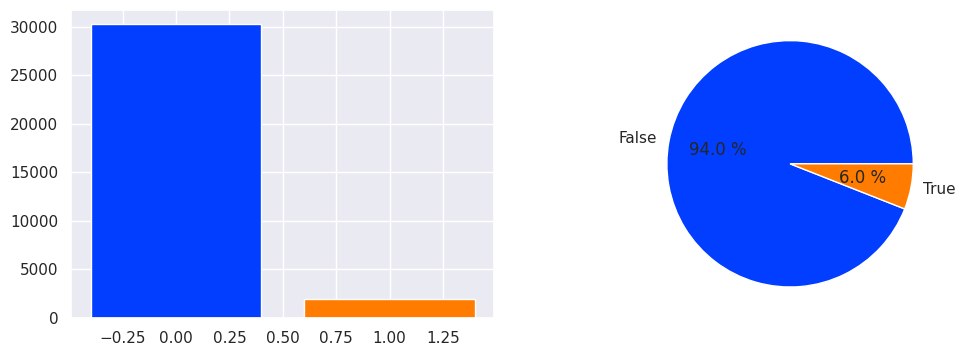

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
juegos_free = juegos.free.value_counts()
ax[0].bar(juegos_free.index, juegos_free.values, color=sns.color_palette("bright"))
ax[1].pie(juegos_free.values, labels=juegos_free.index, autopct="%0.1f %%", colors=sns.color_palette("bright"))
plt.show()

<p>Como se puede notar, el porcentaje de juegos Free to Play en la plataforma es de 6%.

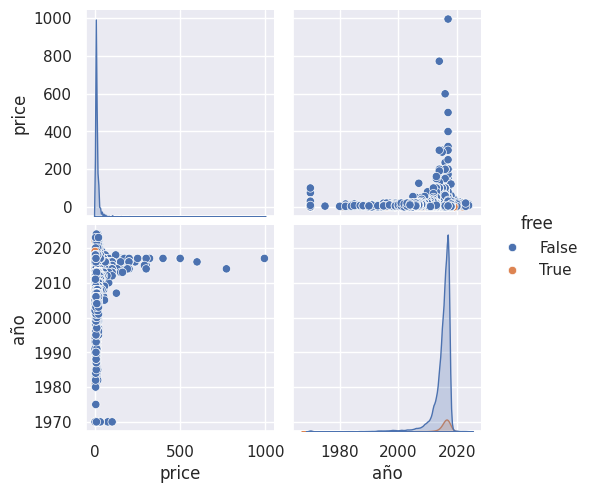

In [ ]:
sns.pairplot(juegos[["price","año","free"]], hue="free")
plt.show()

### Géneros

In [ ]:
generos["cant"] = generos.genre.apply(lambda x: juegos.genres.str.contains(x).sum())
generos

,genre,cant
0,Massively Multiplayer,1147
1,Adventure,8856
2,Web Publishing,273
3,RPG,5610
4,Education,192
5,Free to Play,2214
6,Action,12432
7,Audio Production,110
8,Utilities,425
9,Animation and Modeling,183


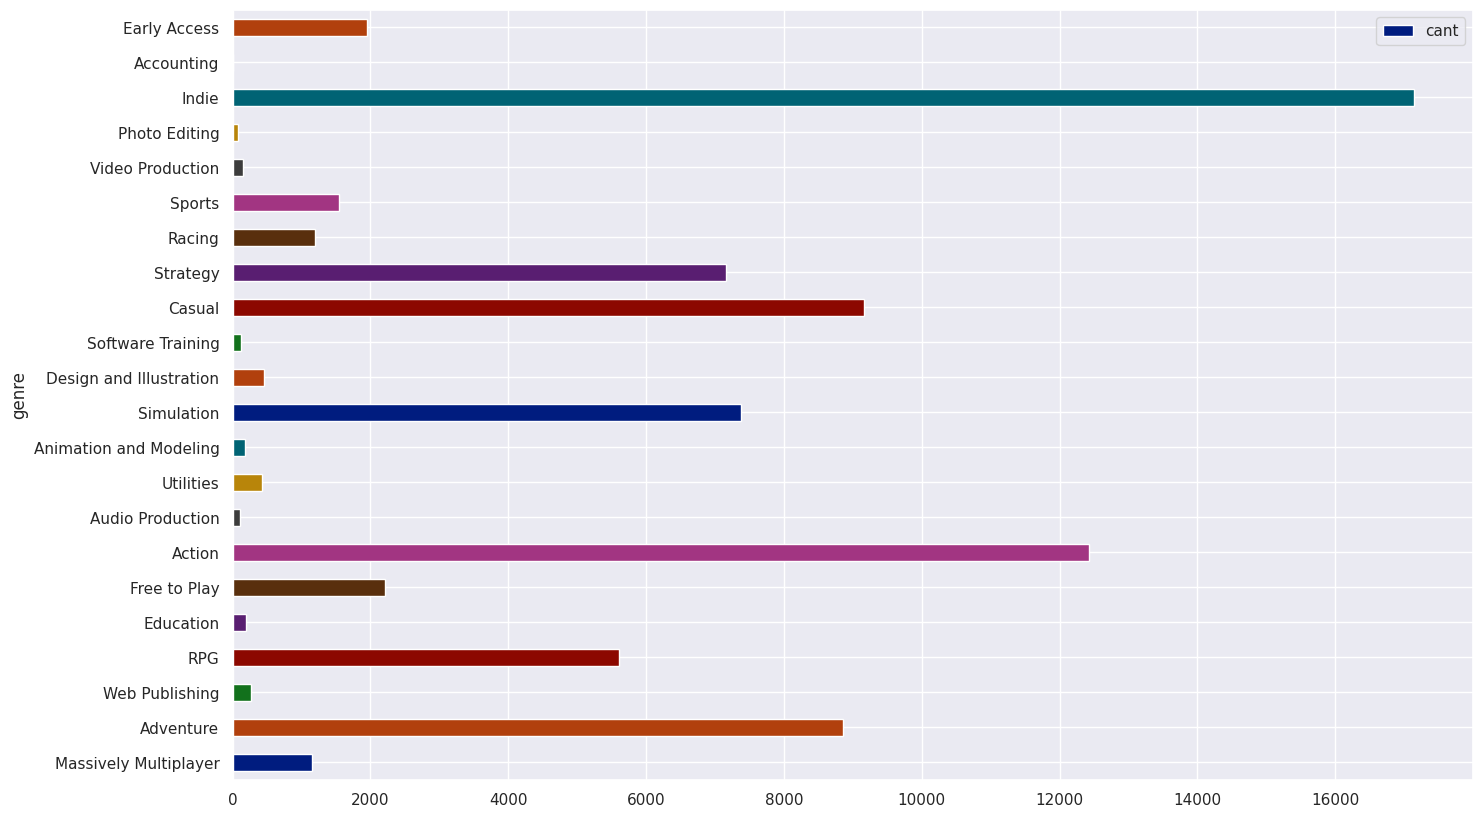

In [ ]:
generos.sort_values(by="cant", ascending=False)
generos.plot.barh(x="genre", y="cant", color=sns.color_palette("dark"), figsize=(16,10))
plt.show()

<p>Este gráfico refuta el planteamiento hecho anteriormente, pues el género con más juegos es el Indie, seguido por Action y Casual.

In [ ]:
generos["free"] = generos.genre.apply(lambda x: juegos[juegos.free].genres.str.contains(x).sum())
generos

,genre,cant,free
0,Massively Multiplayer,1147,276
1,Adventure,8856,527
2,Web Publishing,273,10
3,RPG,5610,383
4,Education,192,25
5,Free to Play,2214,1008
6,Action,12432,691
7,Audio Production,110,4
8,Utilities,425,57
9,Animation and Modeling,183,19


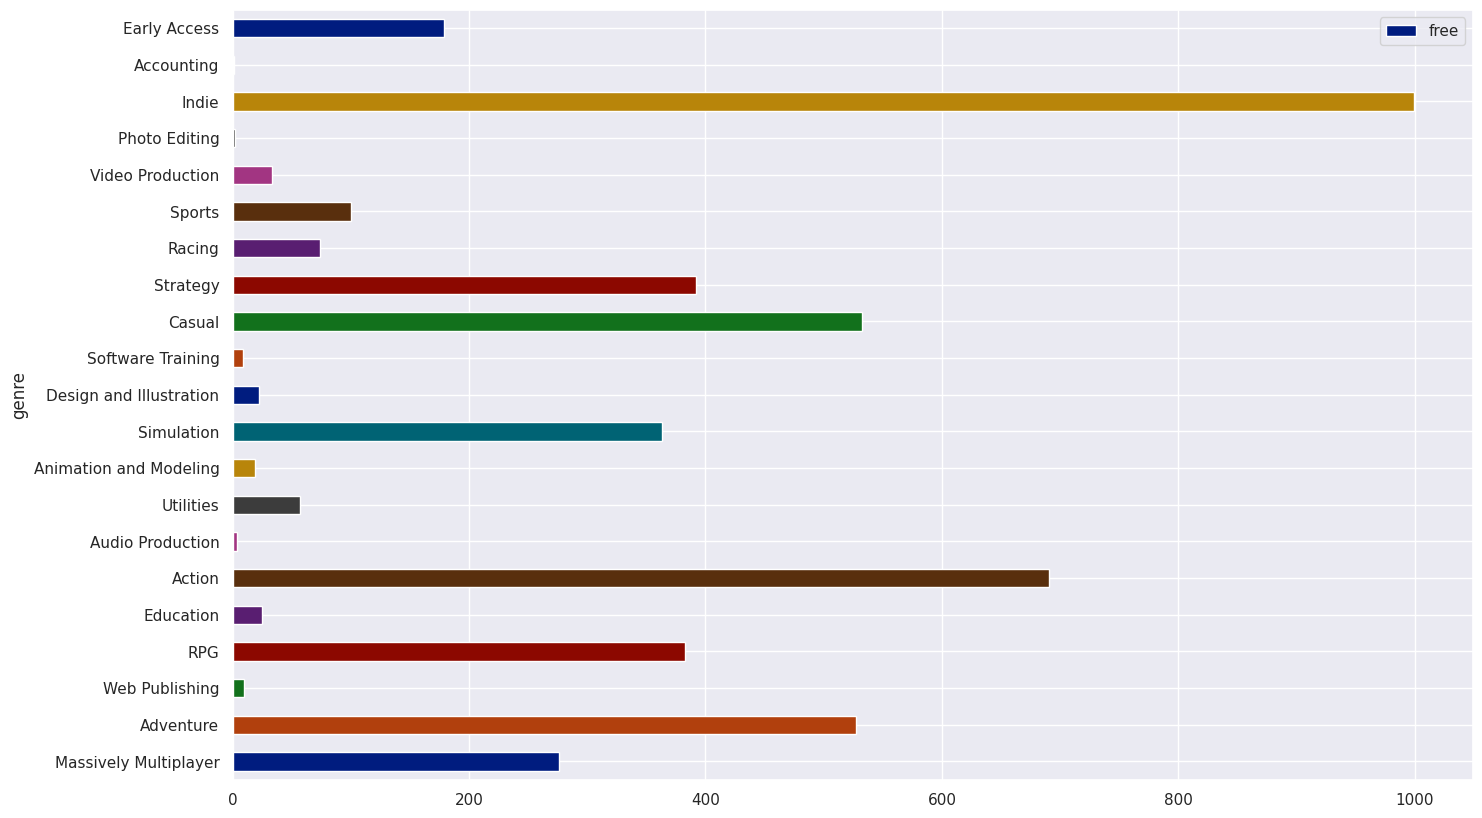

In [ ]:
generos[generos.genre != "Free to Play"].plot.barh(x="genre", y="free", color=sns.color_palette("dark"), figsize=(16,10))
plt.show()

<p>La proporción anterior parece mantenerse para el caso de los juegos Free to Play.

### Desarrolladores

In [ ]:
devs = juegos.developer.value_counts()
devs

developer
Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Lionsgate                      175
                              ... 
Neuronality                      1
Shadow Blade Productions         1
Ionel Zeveleanu                  1
Gambit Games Studio, LLC         1
Bidoniera Games                  1
Name: count, Length: 12970, dtype: int64

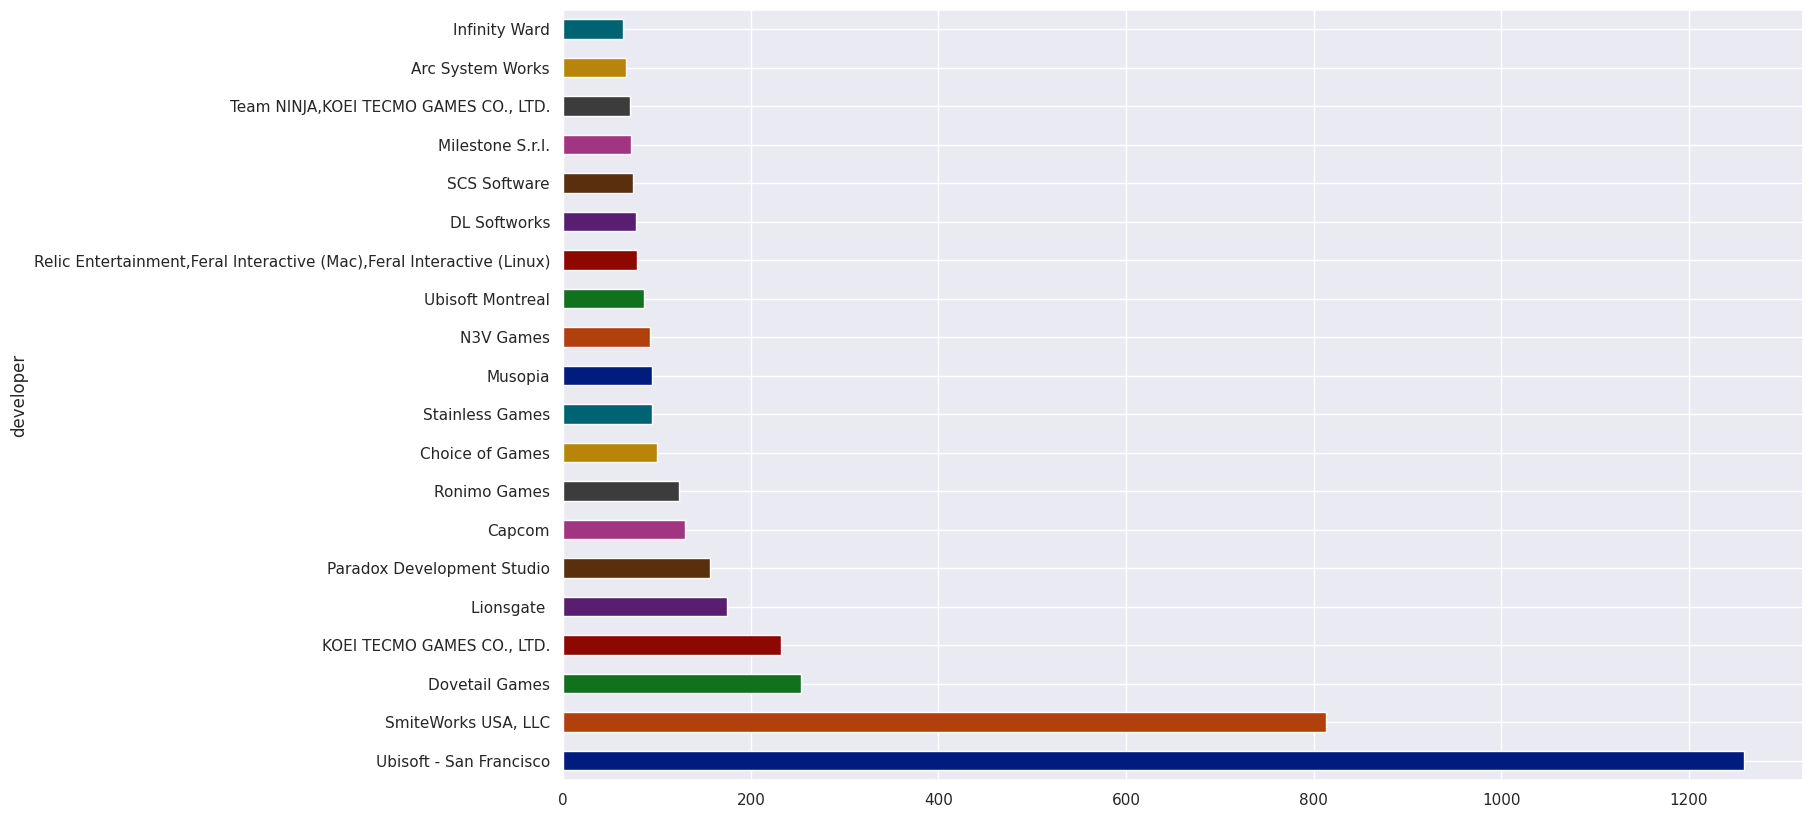

In [ ]:
top20devs = devs.head(20).sort_values(ascending=False)
top20devs.plot.barh(color=sns.color_palette("dark"), figsize=(16,10))
plt.show()

In [ ]:
devs.mean()

2.432922127987664

In [ ]:
devs.median()

1.0

In [ ]:
devs.quantile(0.75)

2.0

<p>El desarrollador con más juegos es (por mucho) Ubisoft San Francisco, con más de 1259, seguido por SmiteWorks con 813. Fuera de estos dos, las desarrolladoras con más de dos juegos tienen cerca de 200, y las que menos tienen 1. Además, más de la mitad de desarrolladores tienen solo un juego en la plataforma, y más del 75% solo uno o dos juegos.

## Análisis multivariable

### Precio promedio y mediano entre los desarrolladores

In [ ]:
precio_dev = juegos[juegos.developer.apply(lambda x: x in top20devs.index)].groupby("developer").price.agg(["mean", "median"]).reset_index().sort_values(by="median", ascending=False)
precio_dev

,developer,mean,median
4,Dovetail Games,16.689644,19.99
10,N3V Games,16.140860,14.99
17,"Team NINJA,KOEI TECMO GAMES CO., LTD.",17.715493,7.99
19,Ubisoft Montreal,9.745930,7.99
6,"KOEI TECMO GAMES CO., LTD.",12.169957,5.99
8,Milestone S.r.l.,10.652083,5.99
15,"SmiteWorks USA, LLC",9.517737,5.99
9,Musopia,4.980000,4.99
11,Paradox Development Studio,7.628462,4.99
13,Ronimo Games,4.486016,4.99


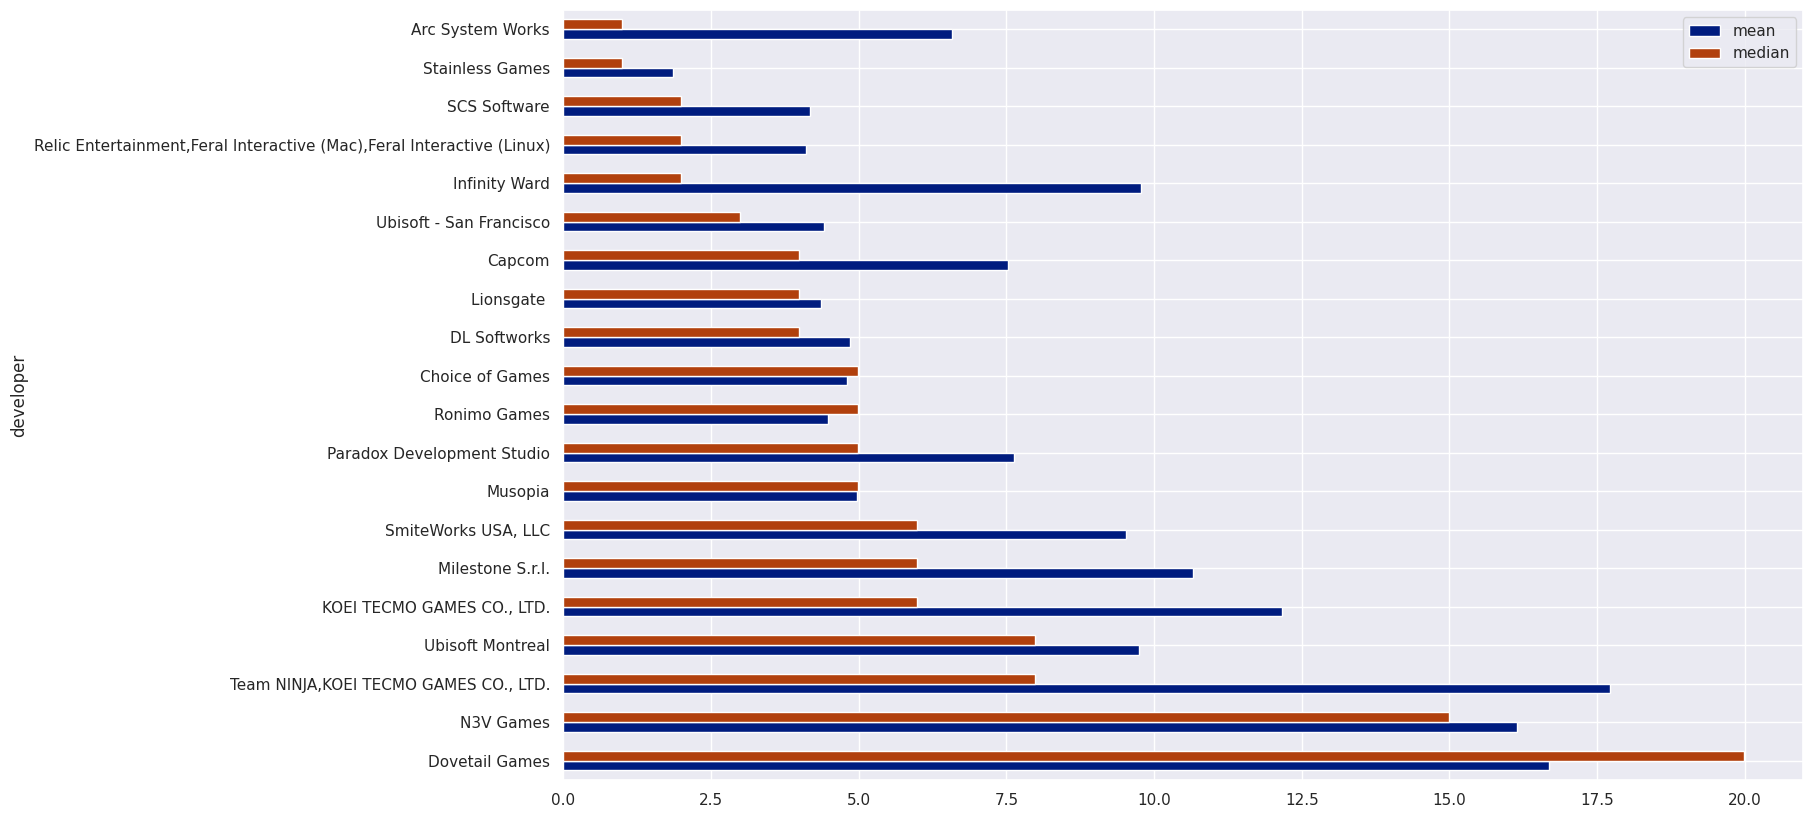

In [ ]:
precio_dev.plot.barh(x="developer", y=["mean", "median"], color=sns.color_palette("dark"), figsize=(16,10))
plt.show()

<p> Según la gráfica anterior, en general los juegos más "caros" entre las desarrolladoras seleccionadas pertenecen a Dovetail Games, N3VGames y el equipo conformado por NINJA y KOEI.

### Precio promedio y mediano entre los géneros

In [ ]:
precio_gen = generos.genre.apply(lambda x: juegos[juegos.genres.str.contains(x)]["price"].agg(["mean", "median"])).set_index(generos.genre).sort_values(by="median", ascending=False)
precio_gen

,mean,median
genre,,
Accounting,37.848571,44.99
Animation and Modeling,53.997158,19.99
Audio Production,34.681727,18.99
Education,33.814740,14.99
Software Training,28.847203,14.99
Design and Illustration,28.740826,12.99
Web Publishing,24.873480,12.99
Video Production,38.131722,9.99
Early Access,9.682373,9.99


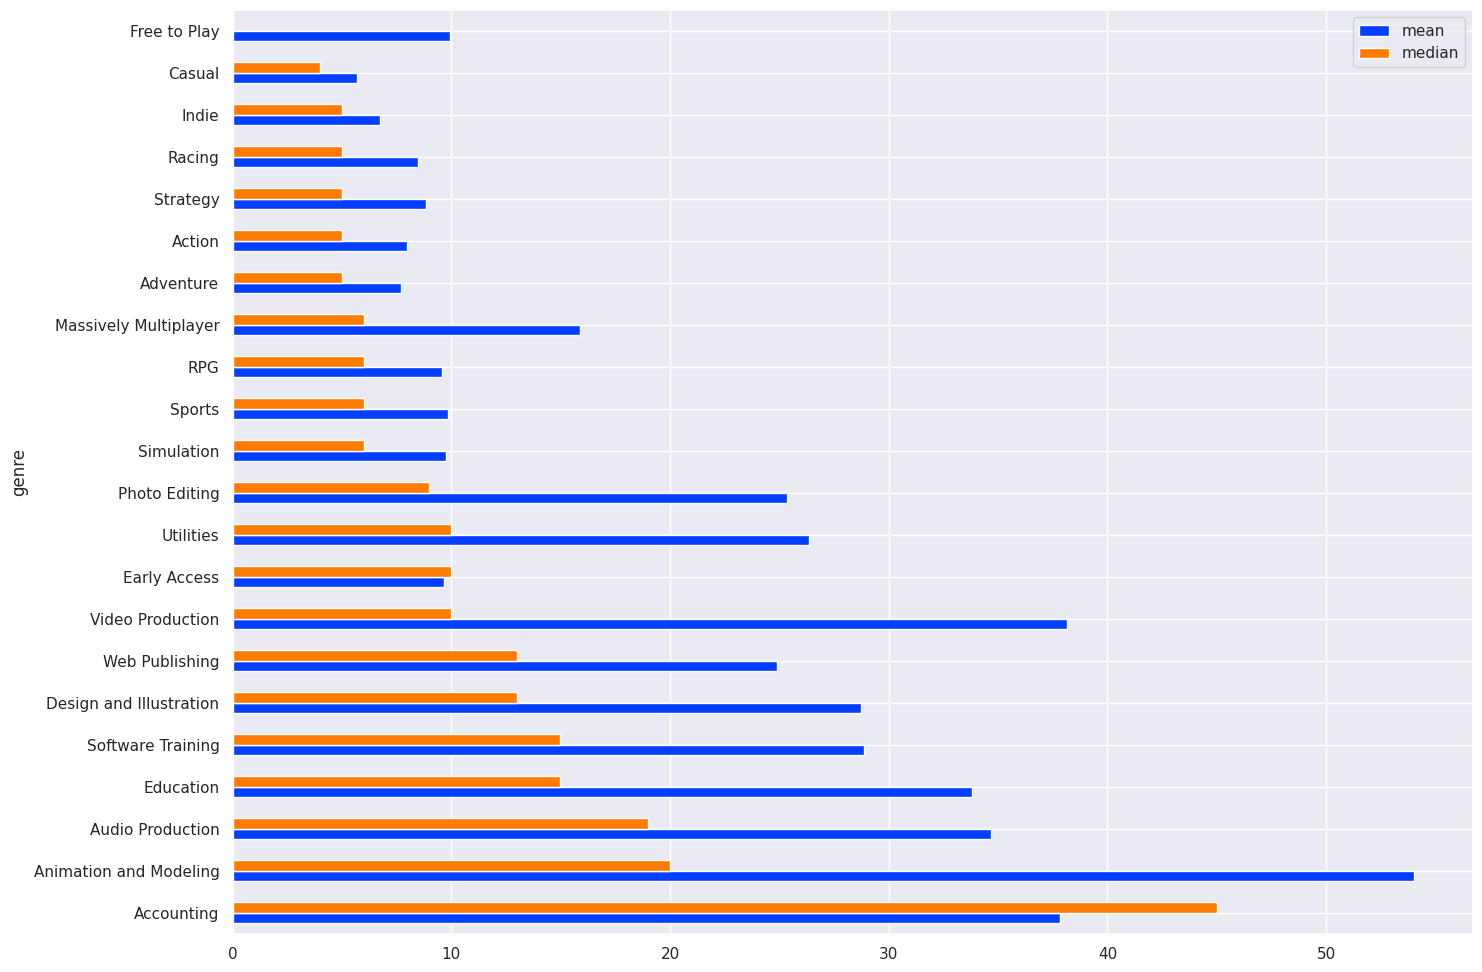

In [ ]:
precio_gen.plot.barh(color=sns.color_palette("bright"), figsize=(16,12))
plt.show()

<p>La gráfica ilustra que los géneros más caros son Accounting, Animation and Modeling y Audio Production, destacando que dado que Video Production tuvo una media bastante alta, algunos de los juegos son también caros. Además, es curioso que la media de Free to Play sea de 10 dólares, cuando el hecho de que un juego sea F2P significa que es gratis. A continuación se ilustrarán los precios máximos para cada categoría.

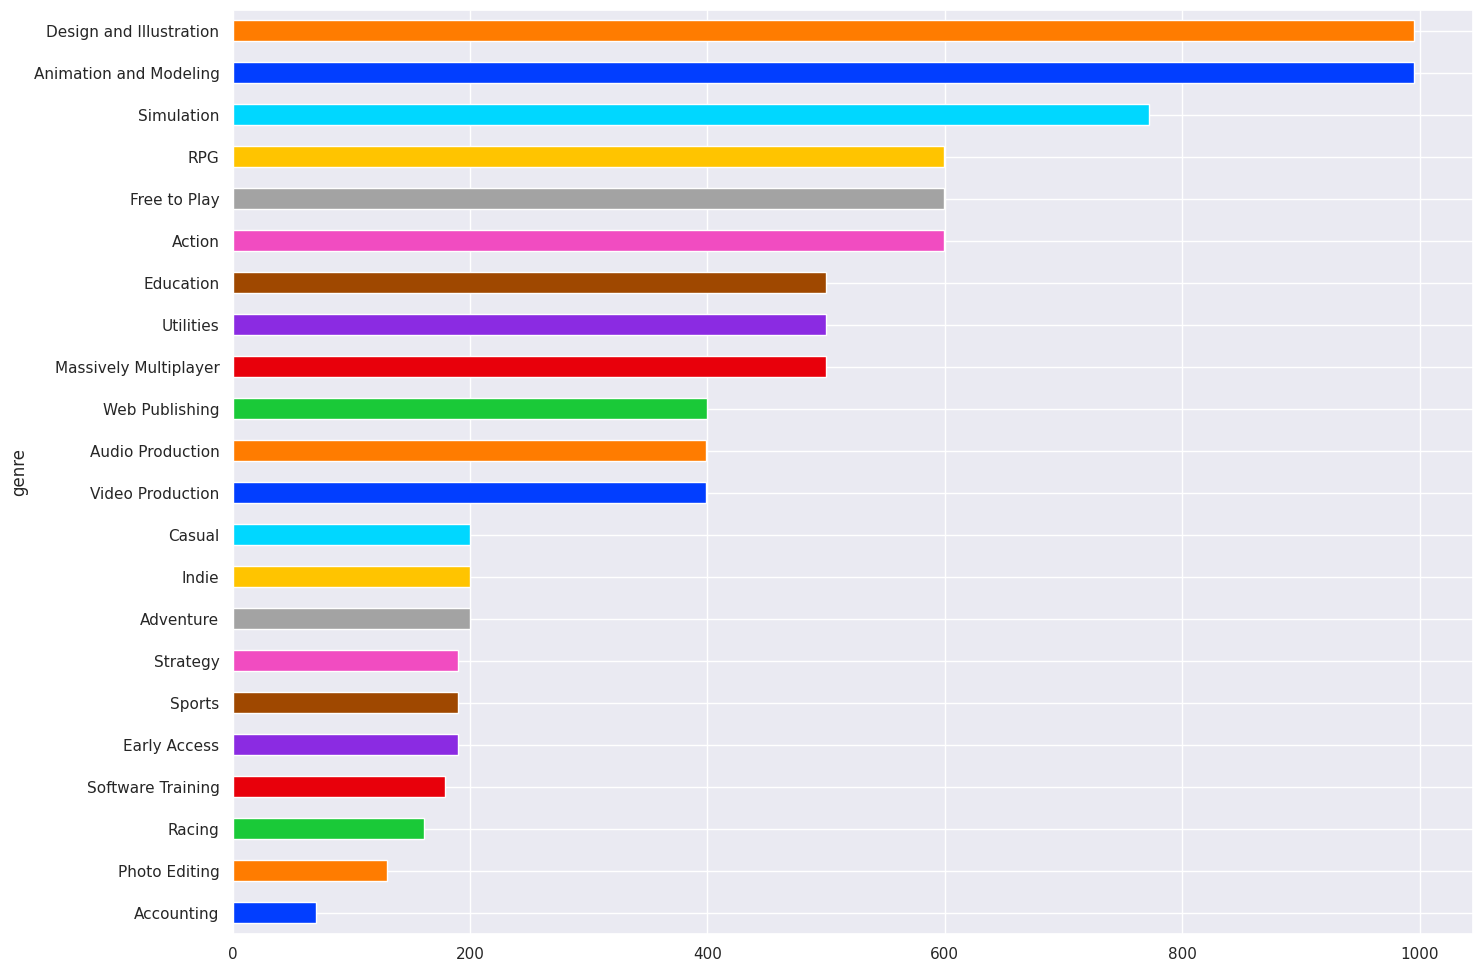

In [ ]:
max_gens = generos.genre.apply(lambda x: juegos[juegos.genres.str.contains(x)]["price"].agg("max"))
max_gens.index = generos.genre
max_gens.sort_values().plot.barh(color=sns.color_palette("bright"), figsize=(16,12))
plt.show()

<p>La gráfica muestra que el juego más caro tiene los géneros Design and Illustration y Animation and Modeling. Además, un juego etiquetado como Free to Play (y también RPG y Action) cuesta cerca de 600 dólares.

### Desarrolladores y años

<p>A continuación se explorará en qué años los 20 desarrolladores con más cantidad de juegos los publicaron.

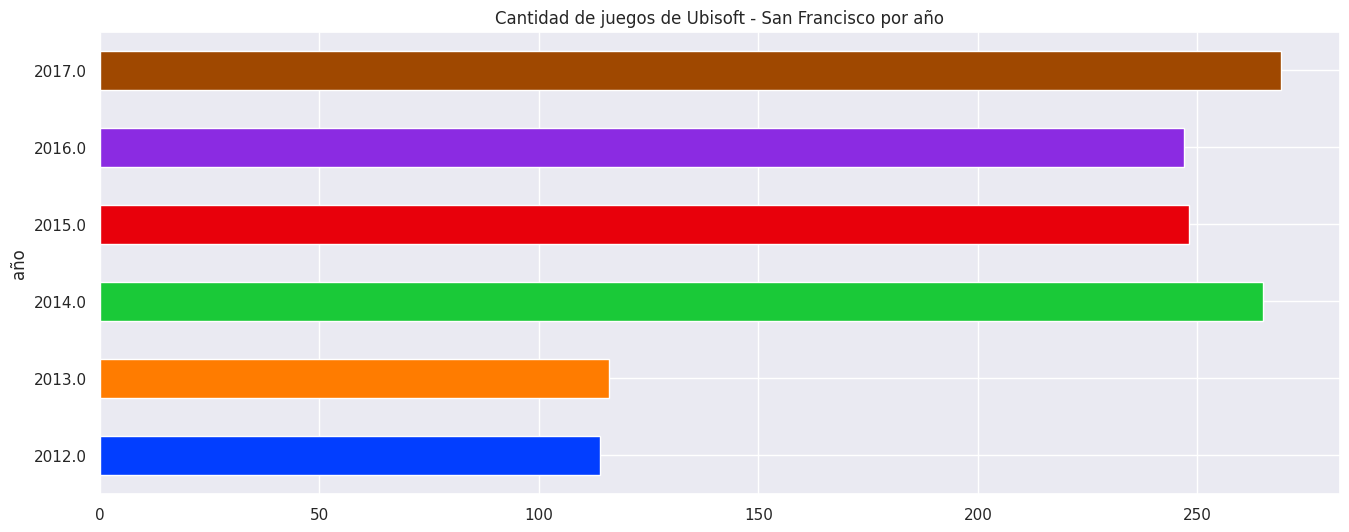

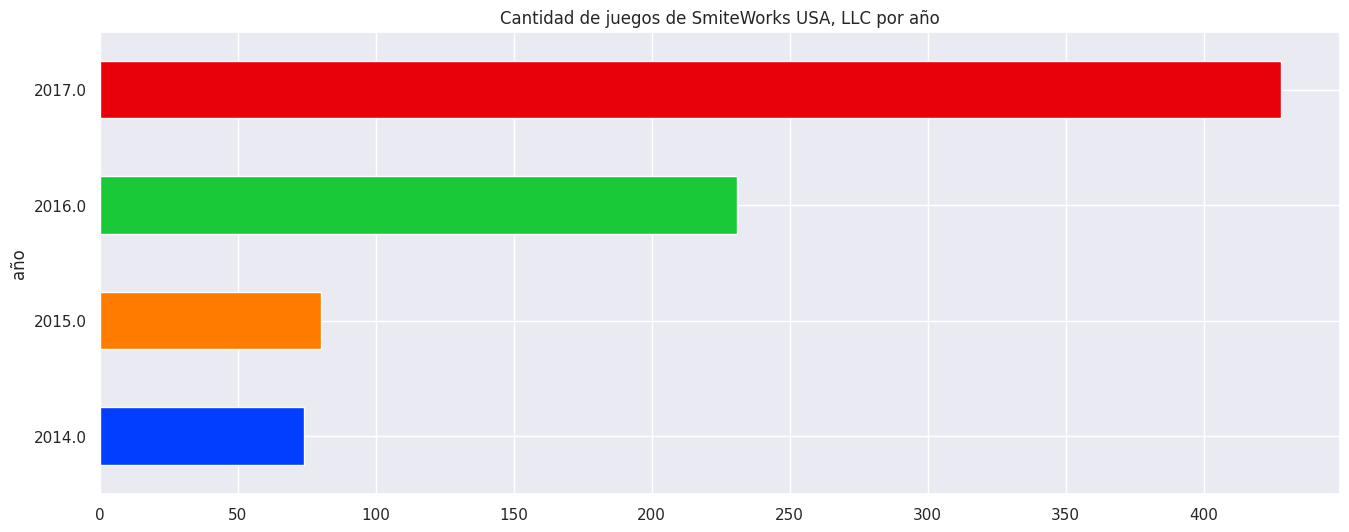

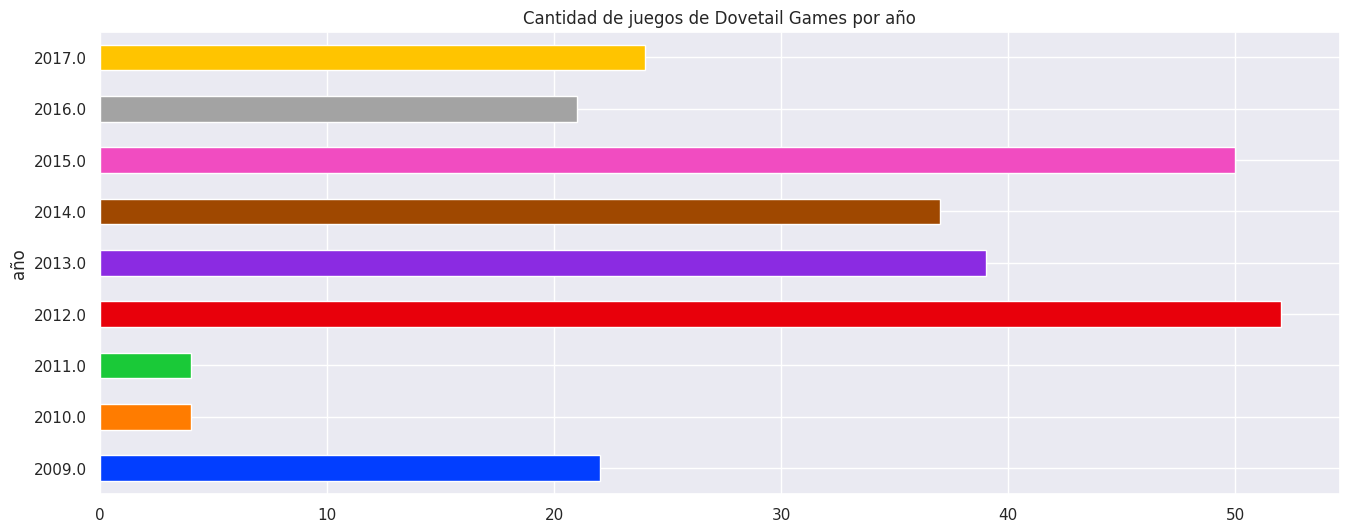

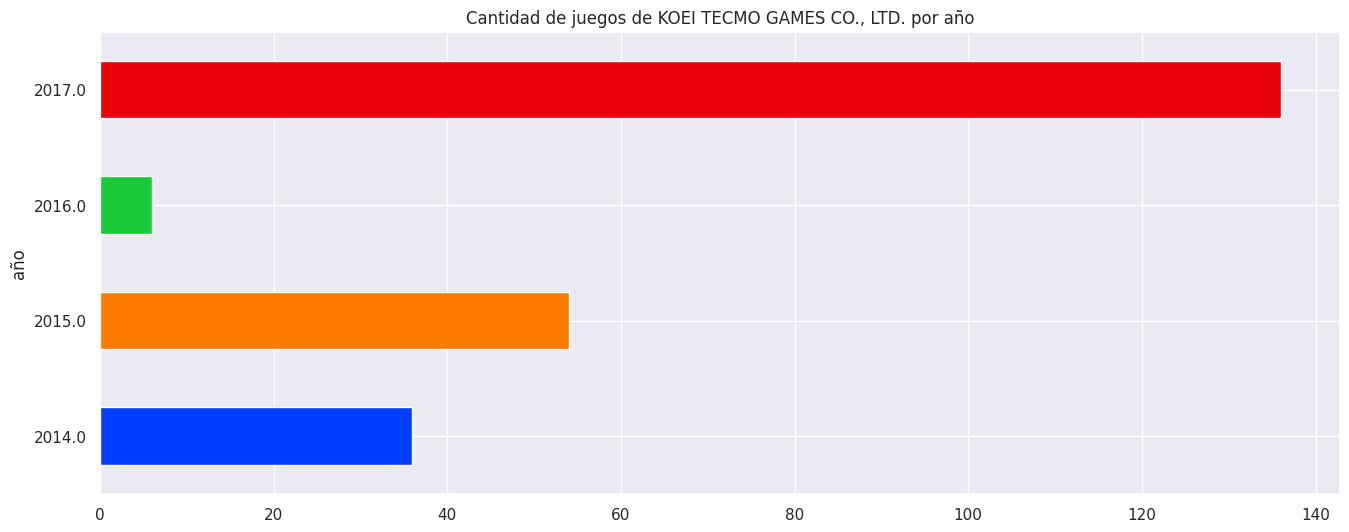

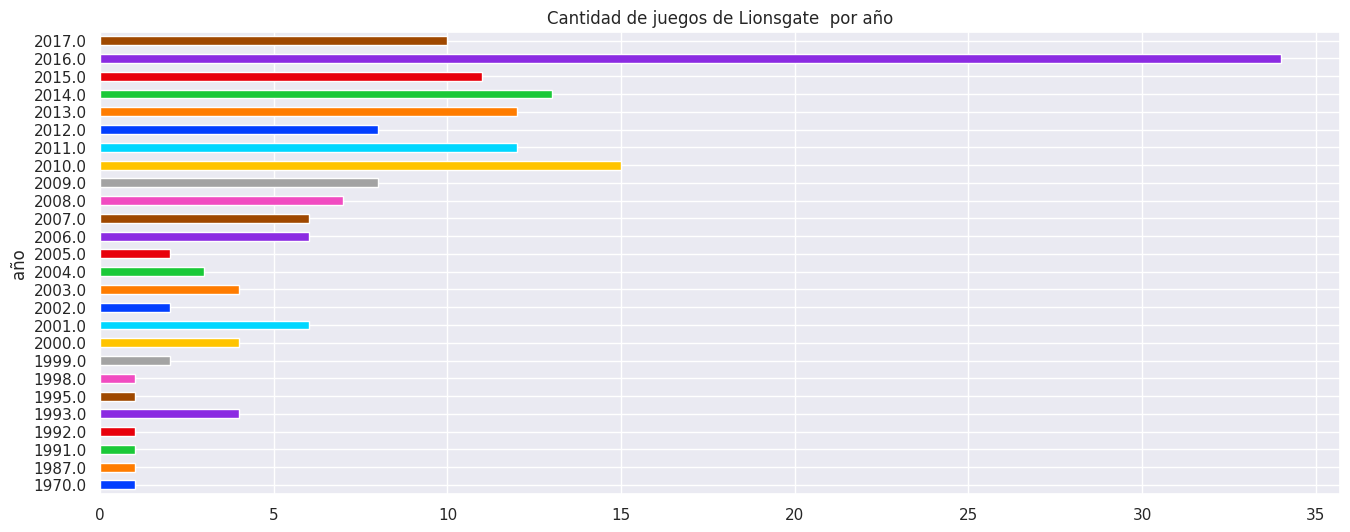

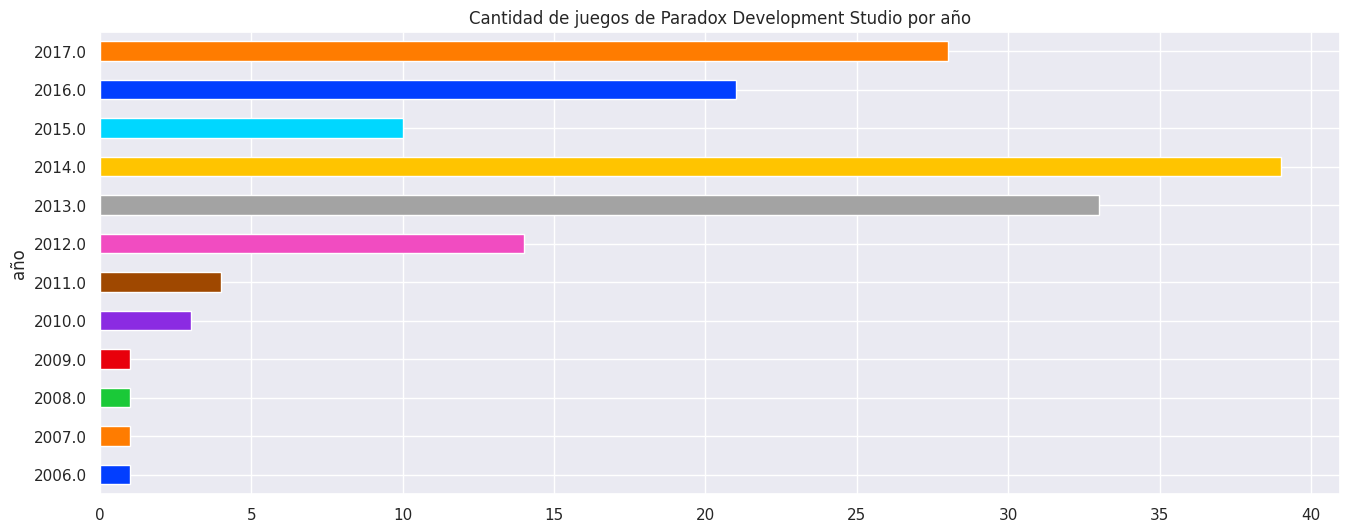

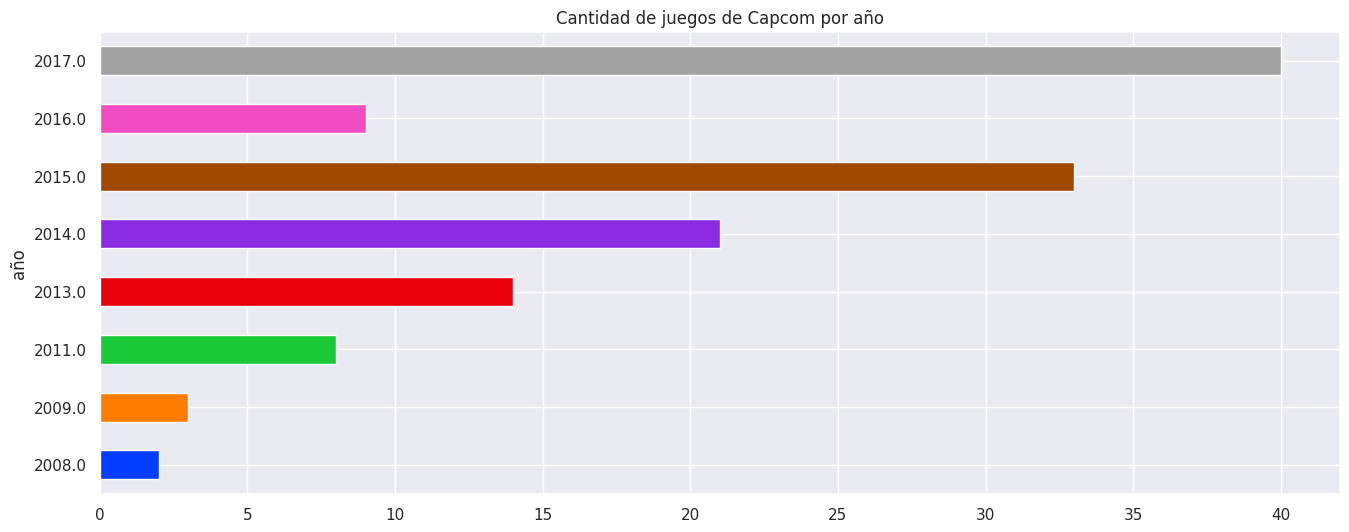

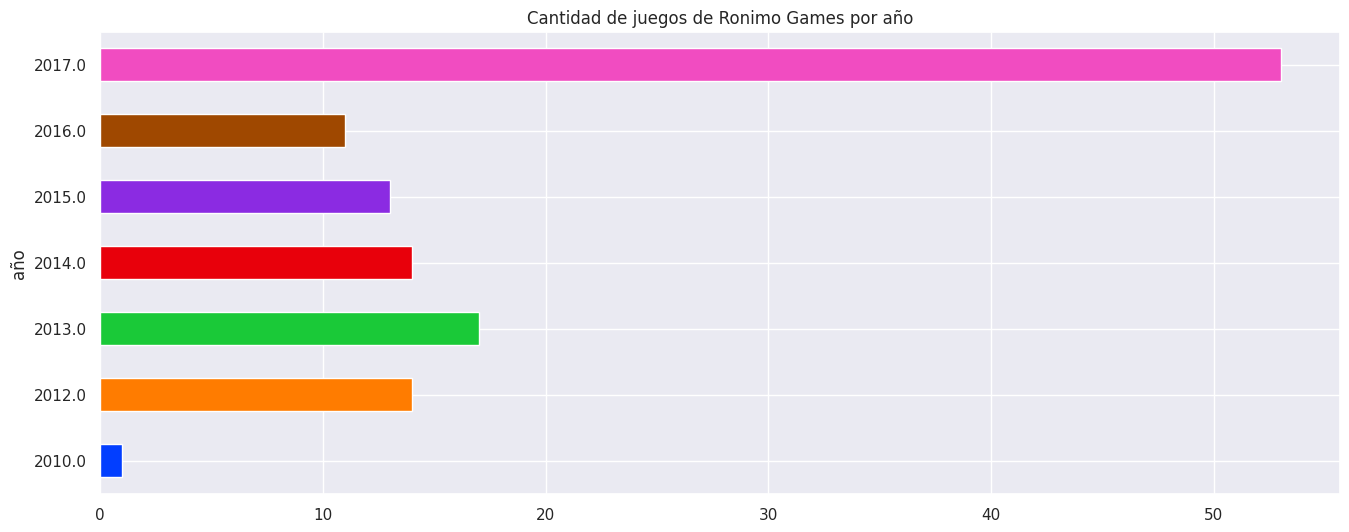

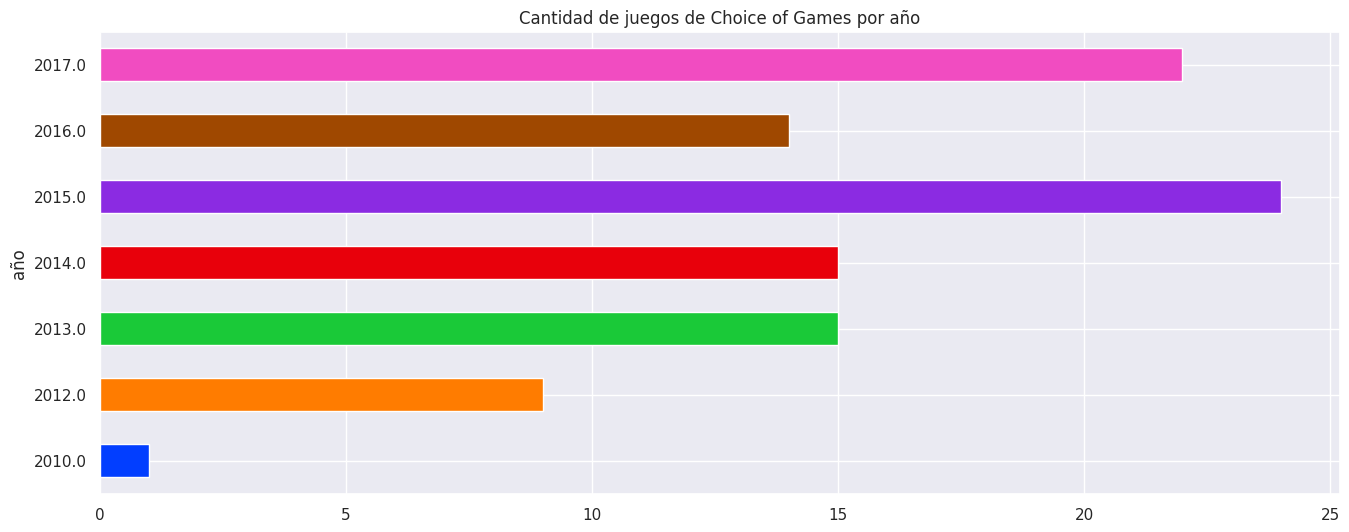

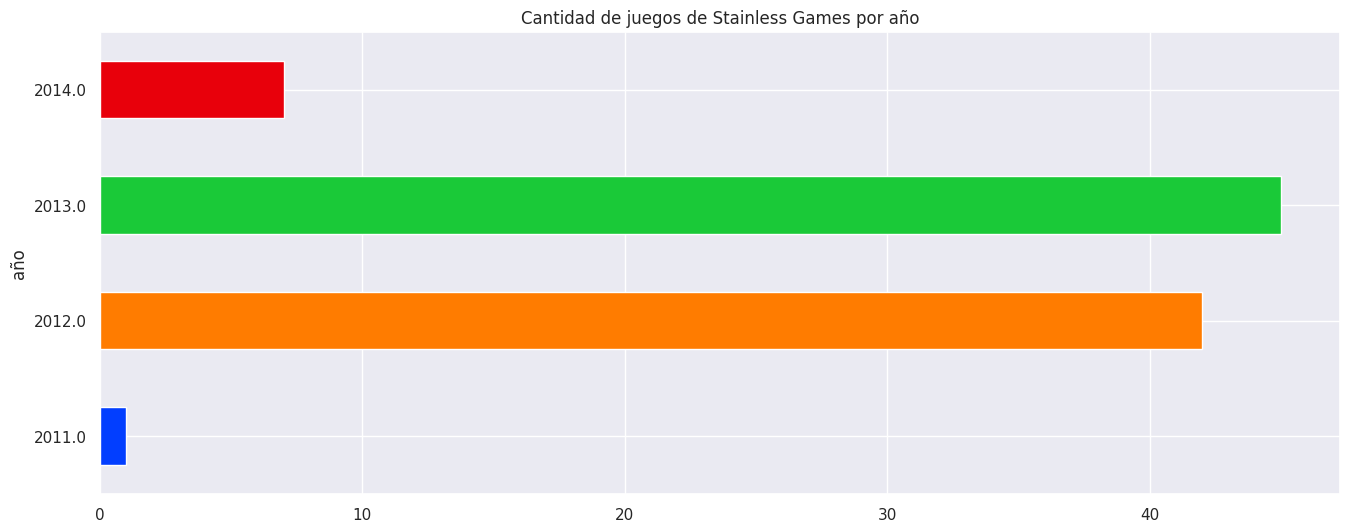

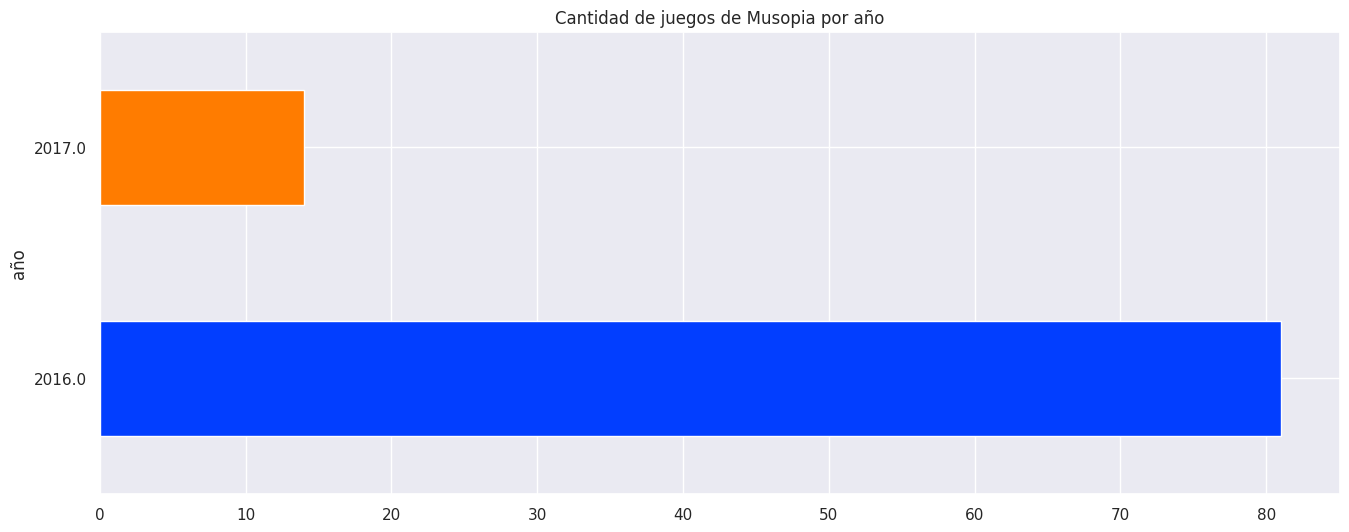

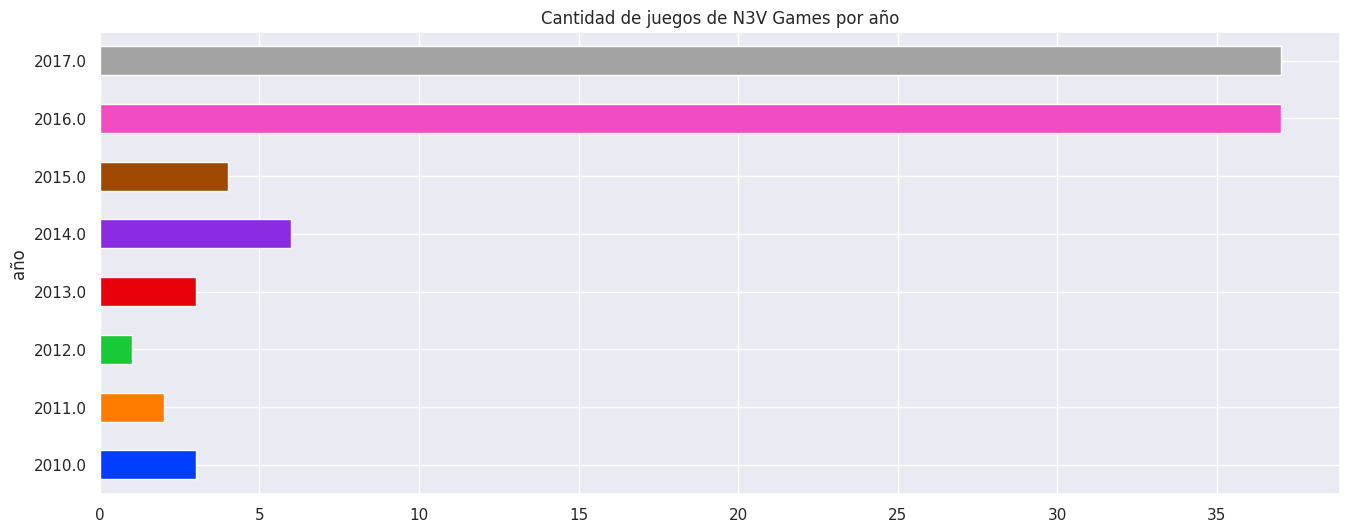

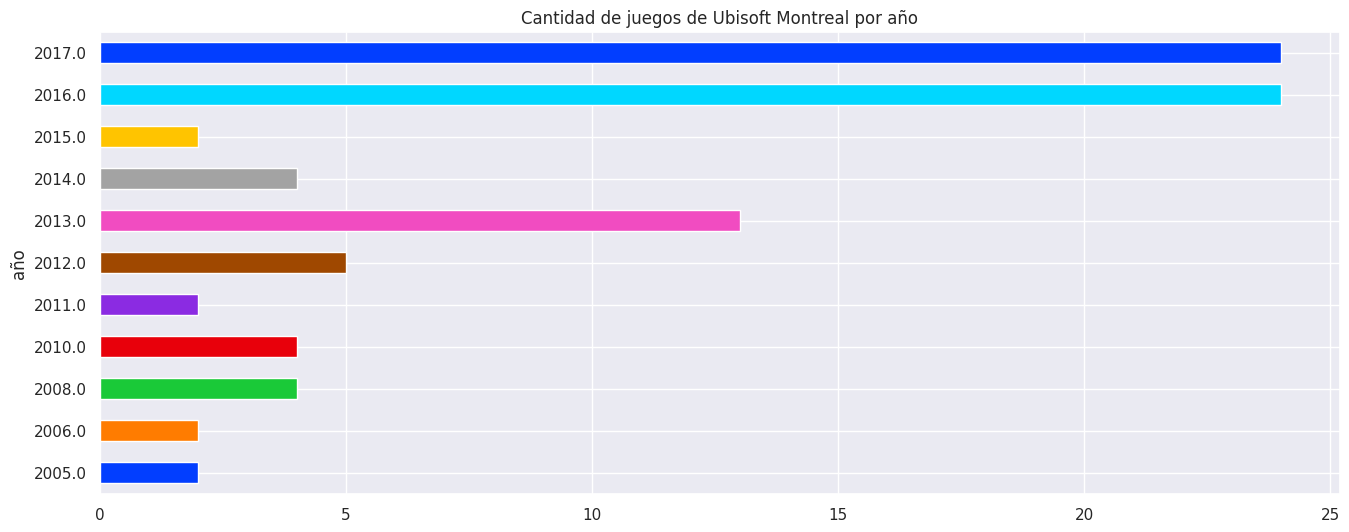

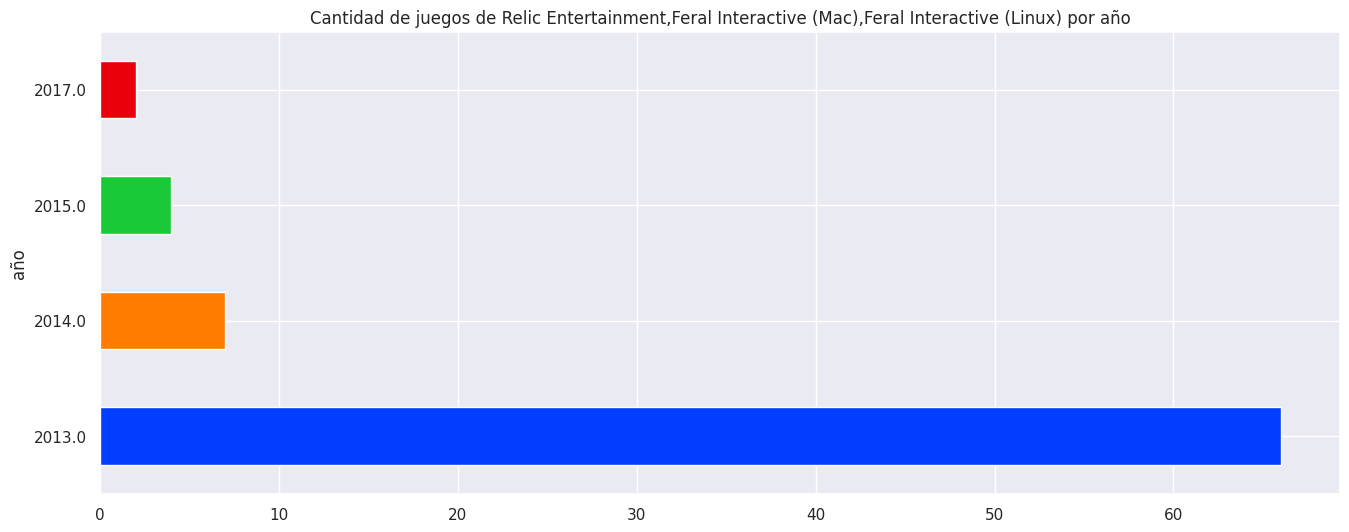

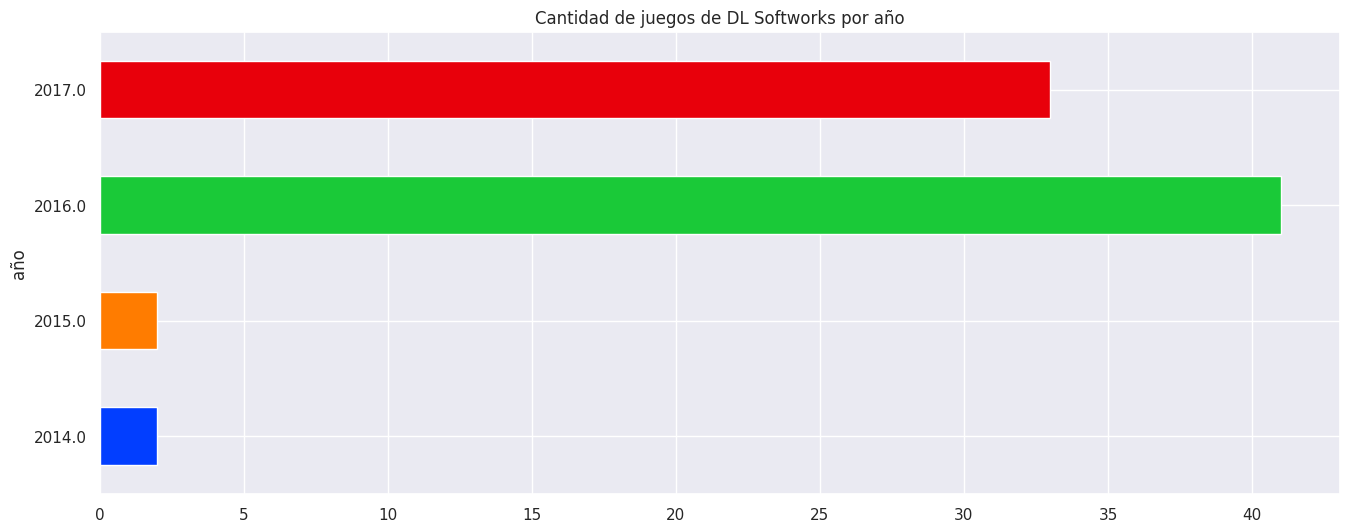

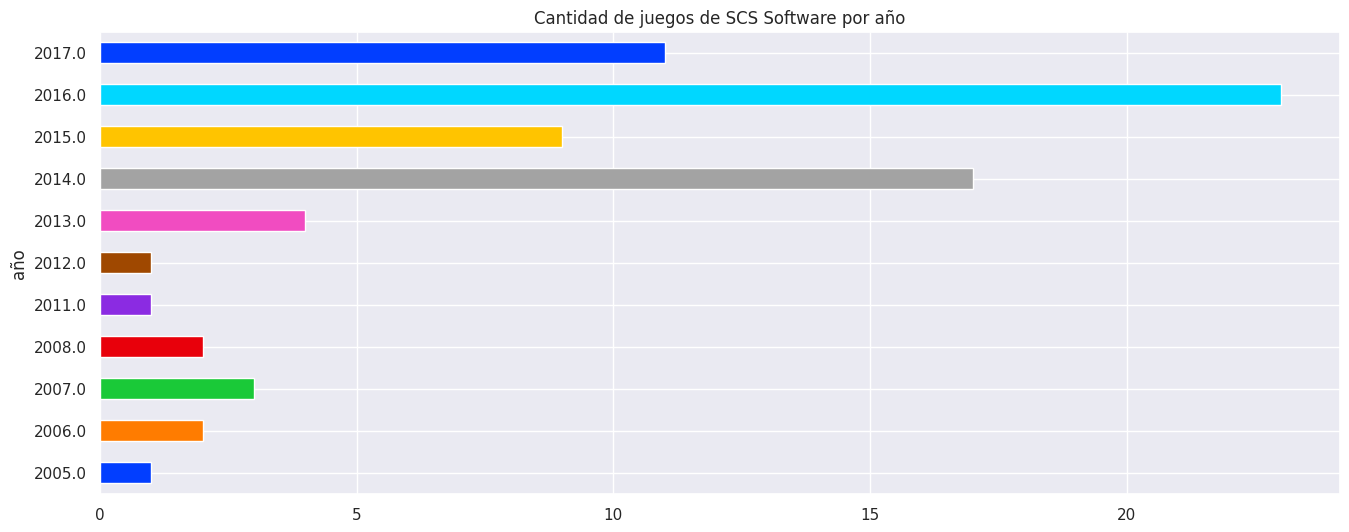

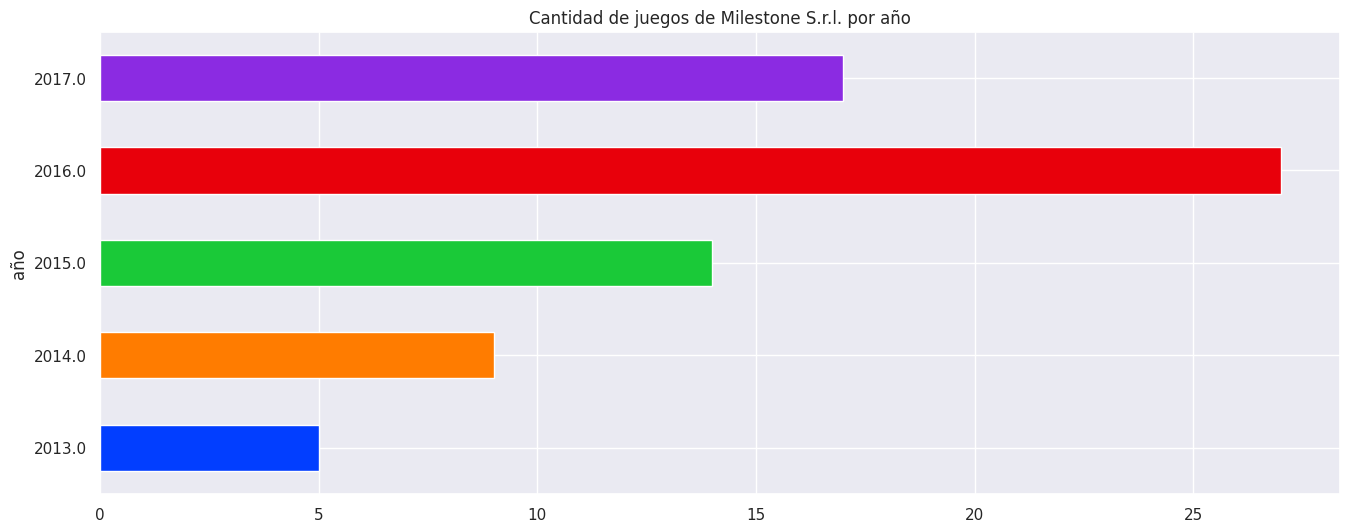

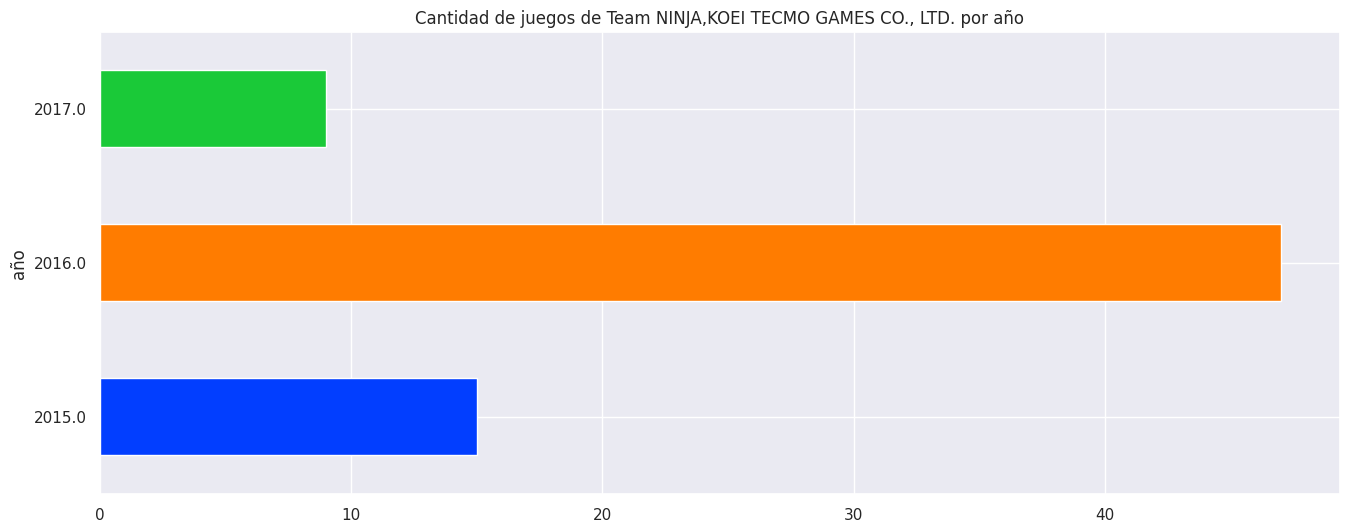

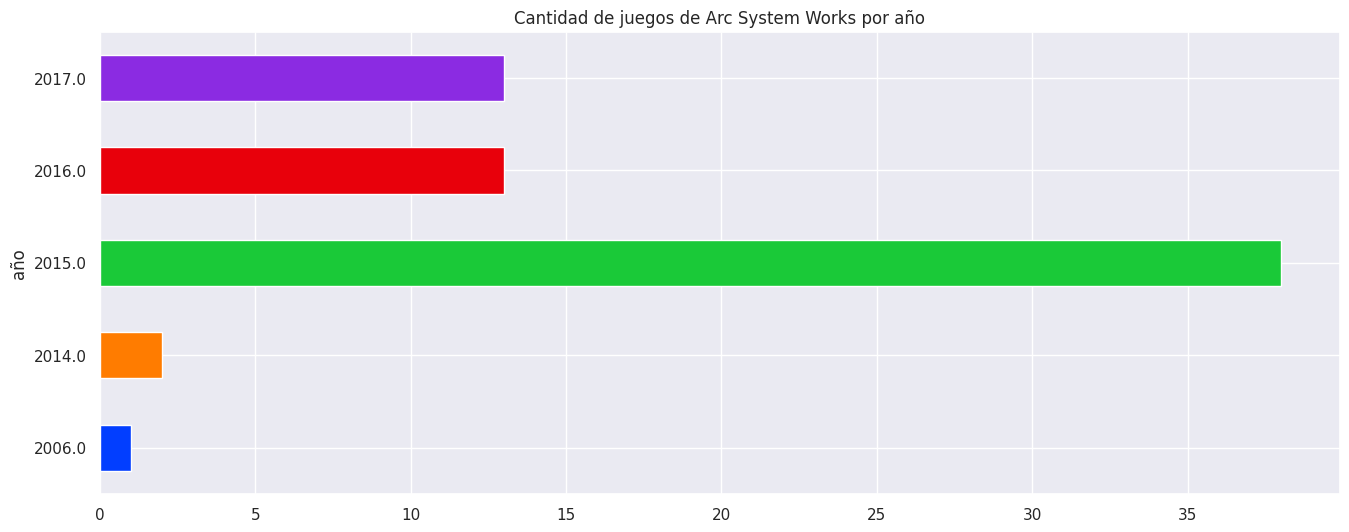

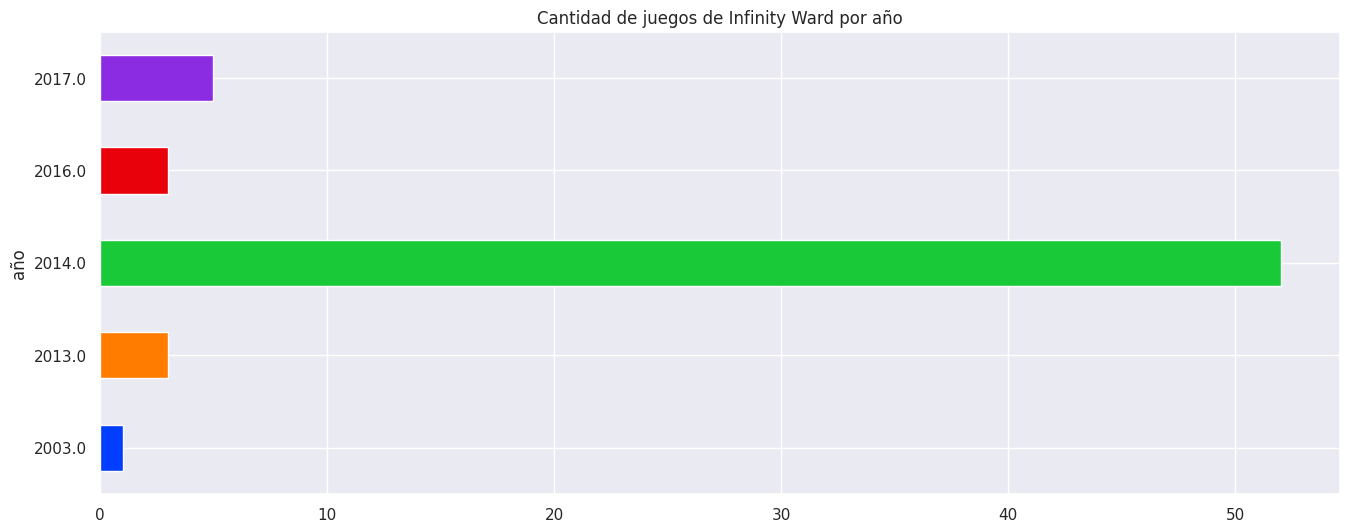

In [ ]:
juegos_top20 = juegos[juegos.developer.apply(lambda x: x in top20devs.index)]
for dev in top20devs.index:
    juegos_top20[juegos_top20.developer == dev].groupby("año").size().sort_index(ascending=True).plot.barh(color=sns.color_palette("bright"), figsize=(16,6))
    plt.title(f"Cantidad de juegos de {dev} por año")
    plt.show()
    plt.show()

<p>De estas gráficas se puede inferir que:

- Las desarrolladoras que más tiempo tienen publicando juegos son Lionsgate (desde 1970), Ubisoft Montreal, SCS Software (desde 2005), y Paradox (desde 2006). Además, Arc System Works publicó uno en 2006 e Infinity Ward uno en 2004, pero su principal tiempo de acción, al igual que el de las demás desarrolladoras, es desde 2010 en adelante.
- Ubisoft San Francisco y SmiteWorks USA tienen publicados más juegos por año en promedio que las demás desarrolladoras.

# Reviews

In [ ]:
reviews.head()

,item_id,recommend,review,user_id,sentiment_analysis
0,1250,True,Simple yet with great replayability. In my opi...,76561197970982479,2
1,22200,True,It's unique and worth a playthrough.,76561197970982479,1
2,43110,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,2
3,251610,True,I know what you think when you see this title ...,js41637,2
4,227300,True,For a simple (it's actually not all that simpl...,js41637,2


In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_id             58431 non-null  int64 
 1   recommend           58431 non-null  bool  
 2   review              58393 non-null  object
 3   user_id             58431 non-null  object
 4   sentiment_analysis  58431 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
reviews.describe()

,item_id,sentiment_analysis
count,58431.000000,58431.000000
mean,169703.670586,1.424946
std,132019.789420,0.671625
min,10.000000,0.000000
25%,8930.000000,1.000000
50%,218230.000000,2.000000
75%,261640.000000,2.000000
max,527340.000000,2.000000


<p>A continuación se muestran los valores de las recomendaciones y del análisis de sentimientos:

<ipython-input-21-023d93afbac5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="recommend", data=reviews, palette="coolwarm", ax=ax[0])


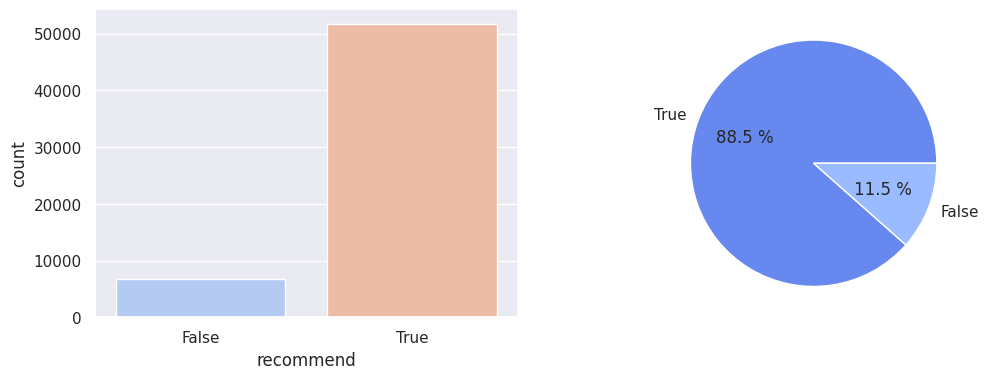

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
recommend = reviews.recommend.value_counts()
sns.countplot(x="recommend", data=reviews, palette="coolwarm", ax=ax[0])
ax[1].pie(recommend.values, labels=recommend.index, autopct="%0.1f %%", colors=sns.color_palette("coolwarm"))
plt.show()

<p>De este gráfico, se puede notar que la mayoría de reseñas (88.5) recomiendan el juego en cuestión.

<ipython-input-18-f0c82325354d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment_analysis", data=reviews, palette="flare", ax=ax[0])


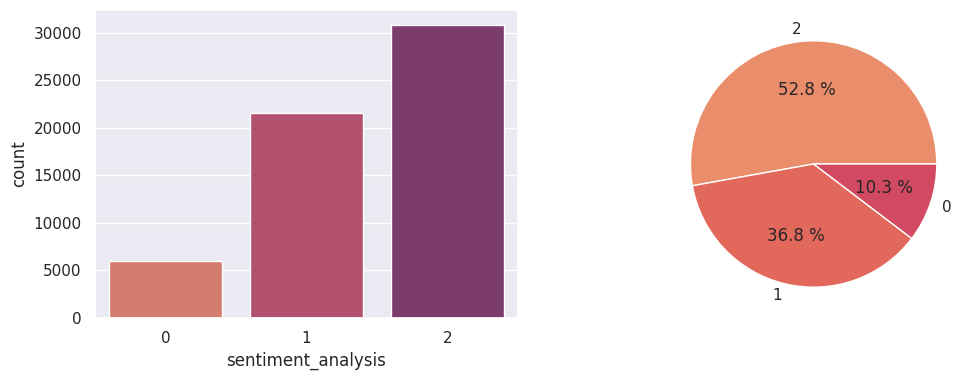

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
score = reviews.sentiment_analysis.value_counts()
sns.countplot(x="sentiment_analysis", data=reviews, palette="flare", ax=ax[0])
ax[1].pie(score.values, labels=score.index, autopct="%0.1f %%", colors=sns.color_palette("flare"))
plt.show()

<p>En resumen, del análisis de sentimientos se tiene que el 52.8% de reseñas son positivas, 36.8% neutrales y 10.3% negativas.

# Items

In [ ]:
items.head()

,item_id,playtime_forever,user_id
0,10,6,76561197970982479
1,20,0,76561197970982479
2,30,7,76561197970982479
3,40,0,76561197970982479
4,50,0,76561197970982479


In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094105 entries, 0 to 5094104
Data columns (total 3 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           int64 
 1   playtime_forever  int64 
 2   user_id           object
dtypes: int64(2), object(1)
memory usage: 116.6+ MB


In [ ]:
items.describe()

,item_id,playtime_forever
count,5.094105e+06,5.094105e+06
mean,1.783916e+05,9.905511e+02
std,1.318516e+05,5.414297e+03
min,1.000000e+01,0.000000e+00
25%,3.445000e+04,0.000000e+00
50%,2.144200e+05,3.400000e+01
75%,2.664300e+05,3.550000e+02
max,5.307200e+05,6.427730e+05


<p>Según la información proporcionada por los cuartiles, el tiempo de juego varía entre 0 y 642.773 horas, aunque el 75% de los valores está cerca o debajo de las 350 horas. Teniendo en cuenta que se trata de información de horas totales jugadas, es de esperar.

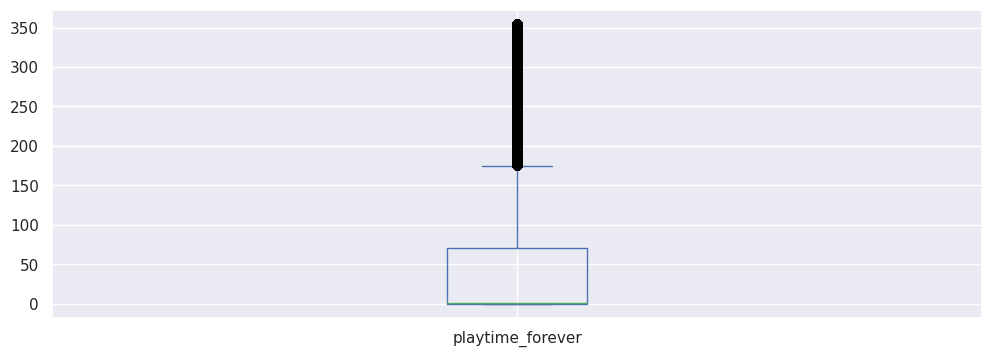

In [ ]:
lim_inf = items.playtime_forever.quantile(0)
lim_sup = items.playtime_forever.quantile(0.75)
mask = (items.playtime_forever >= lim_inf) & (items.playtime_forever <= lim_sup)
items[mask].playtime_forever.plot.box(figsize=(12,4))
plt.show()